### In this notebook, we generate mock observations according to a given distribution of physical parameters. Then we try to recover the underlying distribution. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
popsed.set_matplotlib(style='JL', usetex=False, dpi=80)
from popsed import prior

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

In [3]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_NMF/best_emu/speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol', 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'])

noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

#### Generate mock params

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

In [151]:
def gen_truth(N_samples=5000):
    ncomp = 4
    priors = prior.load_priors([
            # Log stellar mass, in M_sun
            prior.GaussianPrior(10.5, 0.4, label='logm'),
            # flat dirichilet priors for SFH
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
    #         prior.FlatDirichletPrior(ncomp, label='beta'),
            # uniform priors on the mass fraction of burst
            prior.TruncatedNormalPrior(0, 0.6, 0.2, 0.1, label='fburst'),
            # uniform priors on star-burst lookback time
            prior.TruncatedNormalPrior(1e-2, 13.27, 5, 1.5, label='tburst'),
            # uniform priors on log-metallicity, absolute Z
            prior.TruncatedNormalPrior(-2.6, 0.3, -1, 0.3, label='logzsol'),
            # uniform priors on dust1
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.3, label='dust1'),
            # uniform priors on dust2
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.3, label='dust2'),
            # uniform priors on dust_index
            prior.TruncatedNormalPrior(-3., 1., -1, 0.3, label='dust_index'),
            # uniformly sample redshift
            prior.TruncatedNormalPrior(0., 1.5, 0.08, 0.05, label='redshift')
        ])
    
    _thetas_unt = np.array([priors.sample() for i in range(N_samples)])
    _thetas = np.hstack([_thetas_unt[:, 0:1], 
               prior.FlatDirichletPrior(4).transform(_thetas_unt[:, 1:4]), 
               _thetas_unt[:, 4:]])
    
    return _thetas, _thetas_unt

In [152]:
_thetas, _thetas_unt = gen_truth(N_samples=7000)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index


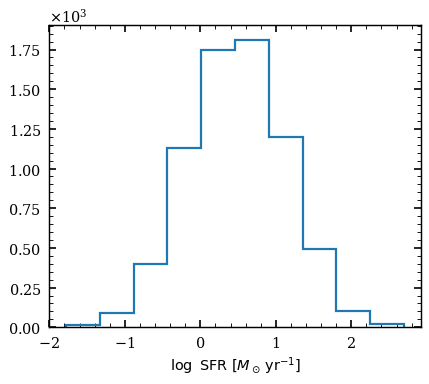

In [153]:
# Check SFR distribution
from popsed.models import NMF
model = NMF(burst=True)

sfr = []
for tt in _thetas:
    sfr.append(model.avgSFR(tt[:-1], zred=tt[-1]))

log_sfr = np.log10(np.array(sfr).T[0])
plt.hist(log_sfr, histtype='step', lw=2)
plt.xlabel(r'$\log\ \mathrm{SFR}\ [M_\odot\,\mathrm{yr}^{-1}]$');

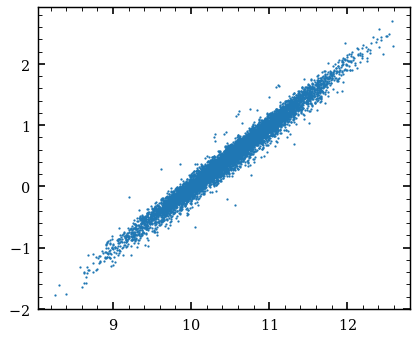

In [154]:
plt.scatter(_thetas[:, 0], log_sfr, s=1)

In [155]:
filters = ['sdss_{0}0'.format(b) for b in 'ugriz']
# filters = ['hsc_{0}'.format(b) for b in 'grizy']
# filters = ['galex_NUV'] + ['hsc_{0}'.format(b) for b in 'grizy'] + ['jwst_f090w', 'jwst_f115w', 'jwst_f140m']
noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [156]:
Y_truth = np.hstack([_thetas_unt[:, 1:], # params taken by emulator, including redshift (for t_age)
                     _thetas_unt[:, 0:1], # stellar mass
                    ])
Y_truth = torch.Tensor(Y_truth).to('cuda')

X_data = speculator._predict_mag_with_mass_redshift(Y_truth, filterset=filters,
    noise=noise, 
    noise_model_dir=noise_model_dir)

flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))
flags = [((Y_truth[:, i] < speculator.bounds[i, 1]) & (Y_truth[:, i] > speculator.bounds[i, 0])).cpu().numpy()
 for i in range(len(speculator.bounds))]
flag = flag.cpu().numpy() & np.array(flags).all(axis=0)

X_data = X_data[flag].detach()
Y_truth = Y_truth[flag]

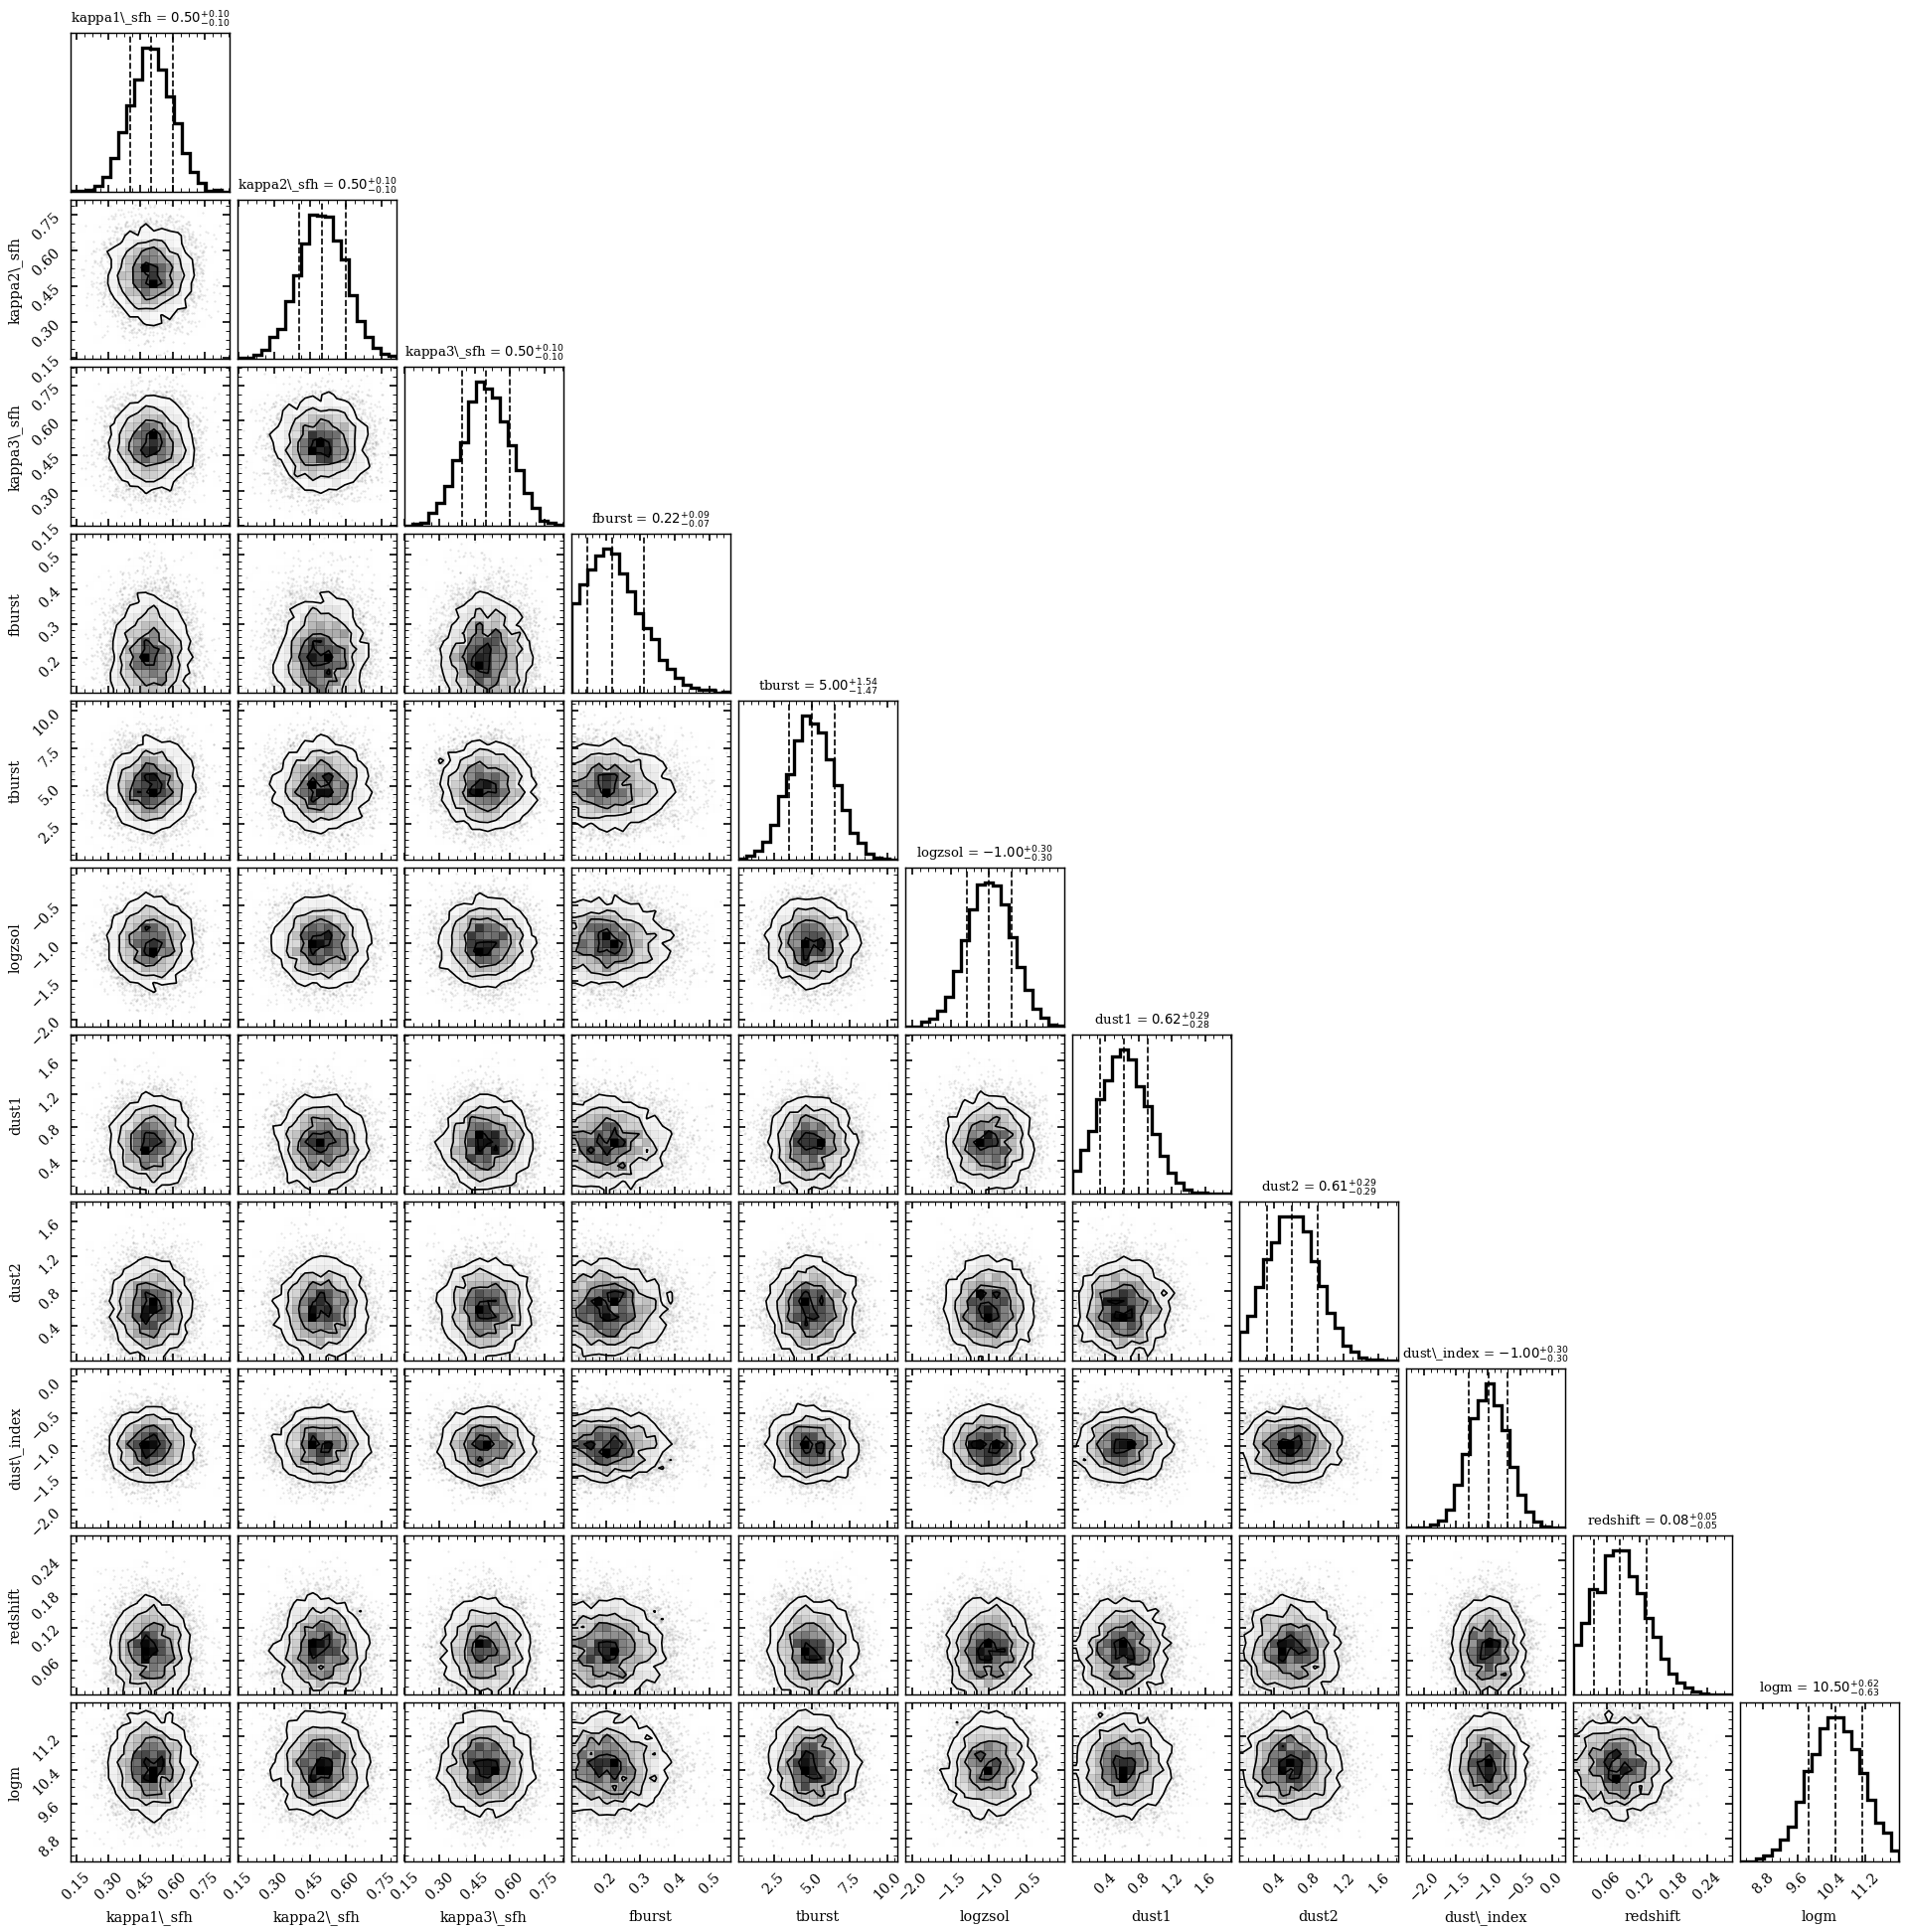

In [157]:
figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=[key.replace('_', '\_') for key in speculator.params_name],
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

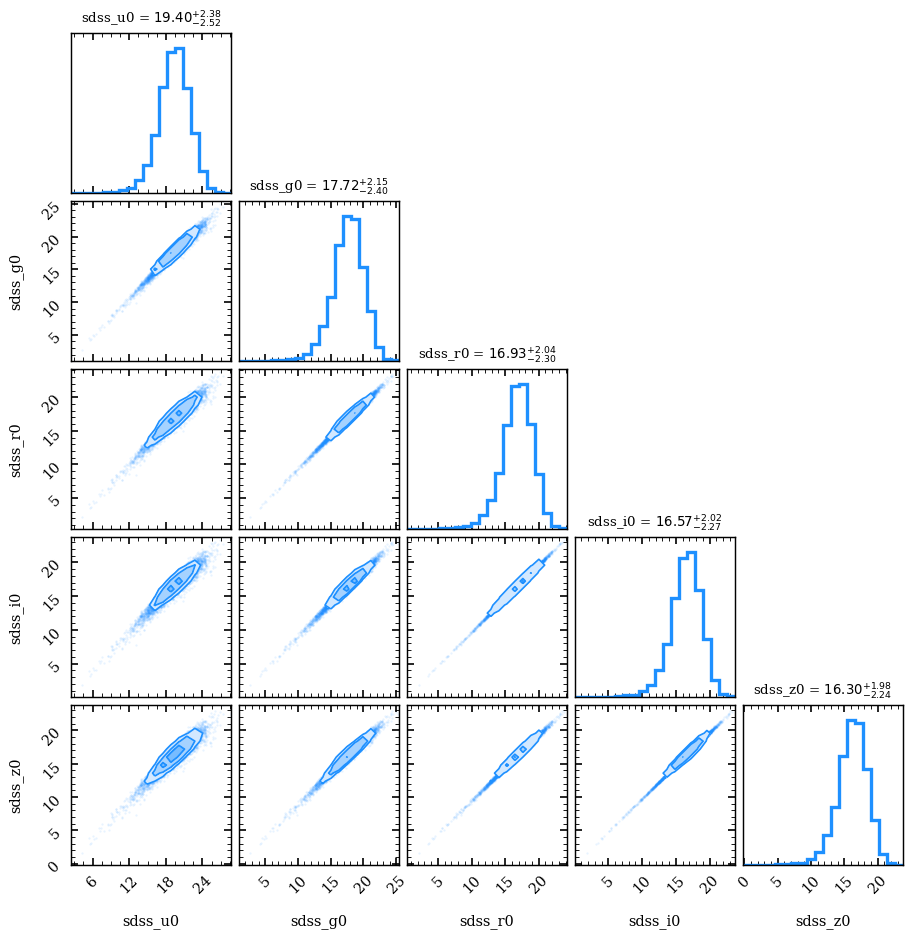

In [158]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = filters # [f'sdss\_{f}0' for f in 'ugriz']

figure = corner.corner(X_data.cpu().detach().numpy()[:, :], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.3, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# nf_plot = corner.corner(X_data.cpu().detach().numpy()[:, :], 
#                         color='dodgerblue', fig=figure, labels=labels,
#                         #quantiles=[0.16, 0.5, 0.84], 
#                         smooth=0.7, fill_contours=True,
#                         show_titles=True, 
#                         title_kwargs={"fontsize": 12},
#                         hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[4]
# ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [159]:
X_train, X_vali, Y_train, Y_vali = train_test_split(X_data, Y_truth, test_size=0.1)

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logm, redshift

In [217]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

np.random.seed(50)

# X_train, X_vali, Y_train, Y_vali = train_test_split(X_data, Y_truth, test_size=0.1)

_bounds = speculator.bounds
for i in range(4):
    _bounds[i] = [0.1, 0.9]
_bounds[-2] = [0, 0.3] # redshift
_bounds[-1] = [8, 12] # log_m
_bounds

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf', num_transforms=15, # 10
                                              num_bins=15, # how smashed it is. 10
                                              hidden_features=50, # 120, 
                                              output_dir=None, 
                                              initial_pos={'bounds': _bounds,
                                                           'std':  [0.3, 0.3, 0.3, 0.3, 3, 
                                                                    0.5, 0.6, 0.6, 0.6, 0.07, 0.4]
                                                          },
                                              normalize=False)
NDE_theta.build(
    Y_train,
    X_train,
    filterset=filters,
    optimizer='adam')

NDE_theta.load_validation_data(X_vali, Y_vali)
NDE_theta.bounds = speculator.bounds

[ 0.20333967  0.15950129  0.58795051  0.11714899  2.02818156  0.16864777
  2.41404768  0.73269027 -1.69921078  0.13179152  8.53915388]


In [218]:
max_epochs = 6
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=6e-4, 
                                                steps_per_epoch=100, 
                                                epochs=max_epochs)
for epoch in range(max_epochs):
    print('lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    NDE_theta.train(n_epochs=100, #50 if epoch==0 else 100,
                speculator=speculator, 
                only_penalty=False if epoch==0 else False,
                noise=noise, noise_model_dir=noise_model_dir,
                sinkhorn_kwargs={'p': 1, 'blur': 0.1, 'scaling': 0.8},
                scheduler=scheduler
               )

lr: 2.400000000000004e-05


Loss = 4.162 (train), 3.310 (bad ratio): 100%|███████████████████████████████████████████| 100/100 [00:46<00:00,  2.16epochs/s]


lr: 0.00036477371982685544


Loss = 0.169 (train), 0.066 (bad ratio): 100%|███████████████████████████████████████████| 100/100 [00:53<00:00,  1.85epochs/s]


lr: 0.0005963065169525325


Loss = 0.339 (train), 0.137 (bad ratio): 100%|███████████████████████████████████████████| 100/100 [00:55<00:00,  1.80epochs/s]


lr: 0.00048528775739769116


Loss = 0.118 (train), 0.070 (bad ratio): 100%|███████████████████████████████████████████| 100/100 [00:55<00:00,  1.79epochs/s]


lr: 0.00027534519849803146


Loss = 0.090 (train), 0.061 (bad ratio): 100%|███████████████████████████████████████████| 100/100 [00:59<00:00,  1.68epochs/s]


lr: 7.856638649659483e-05


Loss = 0.080 (train), 0.053 (bad ratio): 100%|███████████████████████████████████████████| 100/100 [00:55<00:00,  1.81epochs/s]


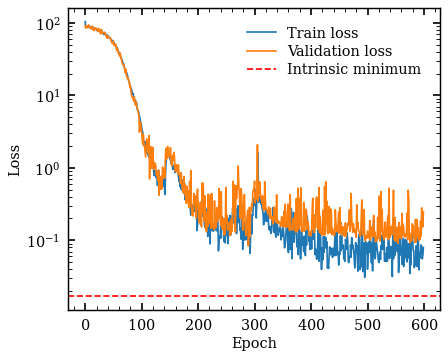

In [219]:
NDE_theta.plot_loss()
plt.yscale('log')

In [220]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

NDE_theta.best_model.goodness_of_fit(Y_truth, p=1)
NDE_theta.goodness_of_fit(Y_truth, p=1)

Best epoch: 496
Best train loss: 0.030827797949314117
Best vali loss: 0.11053439229726791
Log10 Wasserstein distance in theta space:  0.1293540288807116
Log10 Wasserstein distance in theta space:  0.12452024367778404


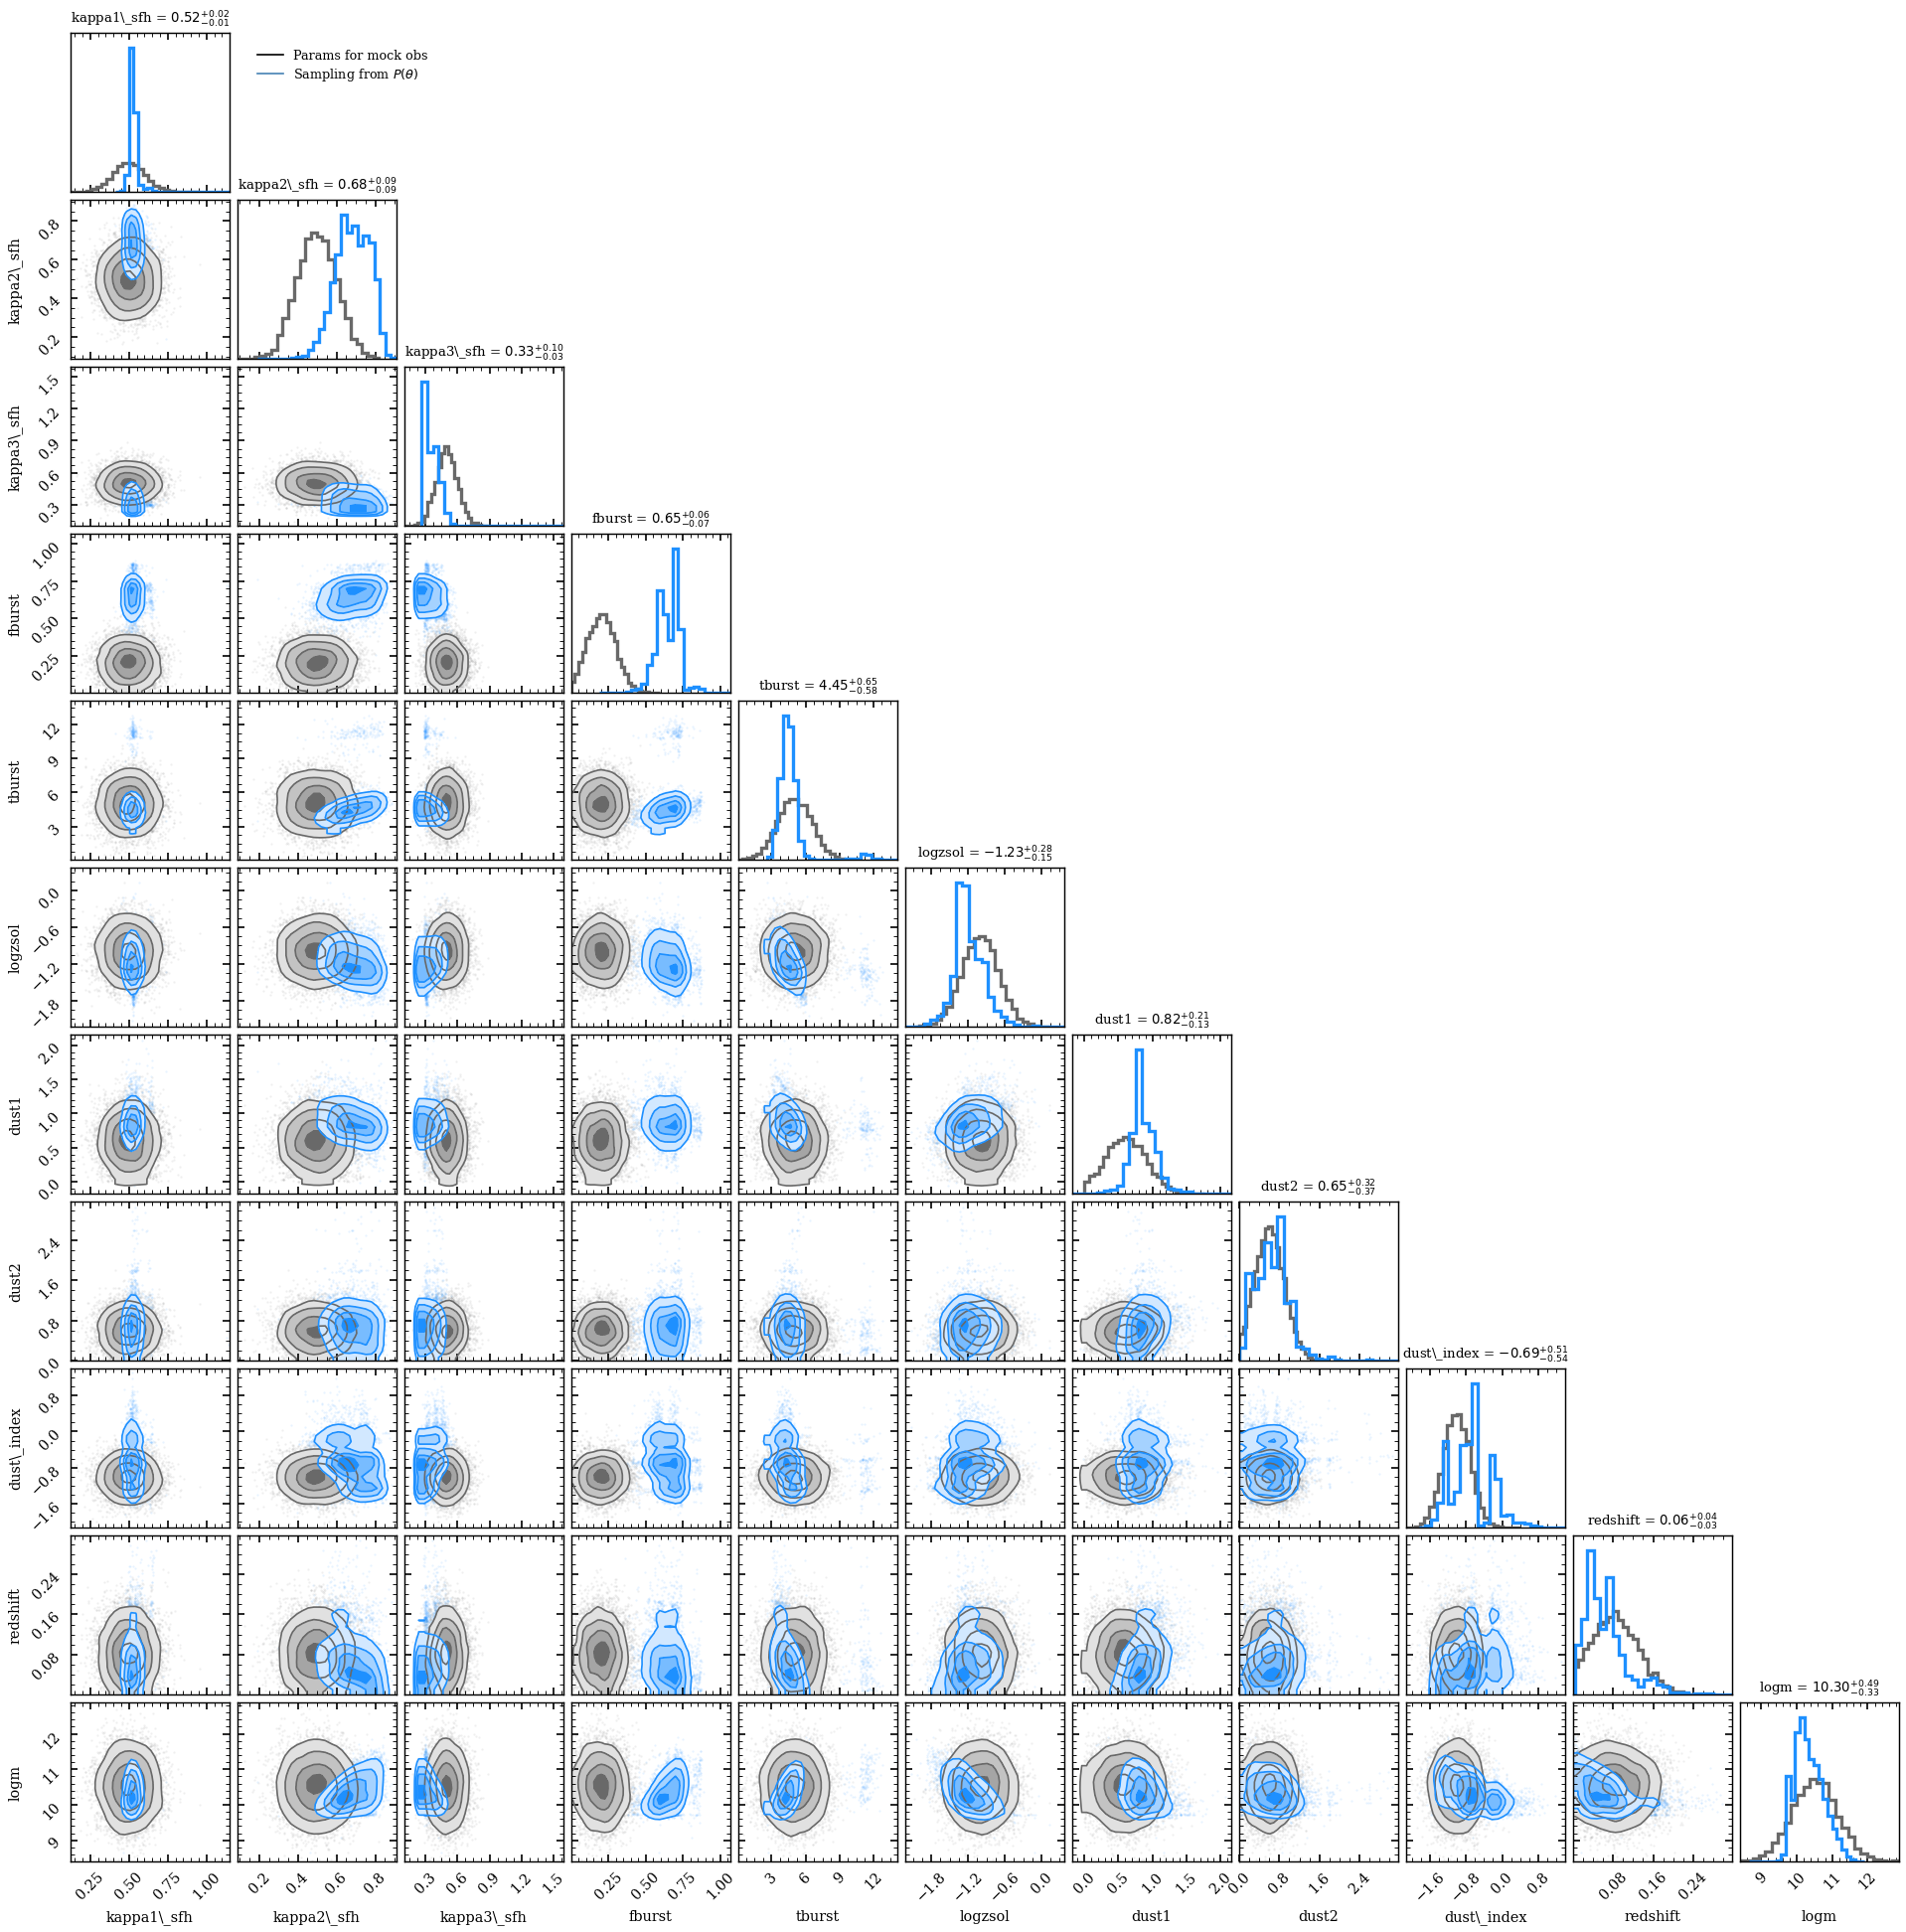

In [222]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

0 5000
>40 0


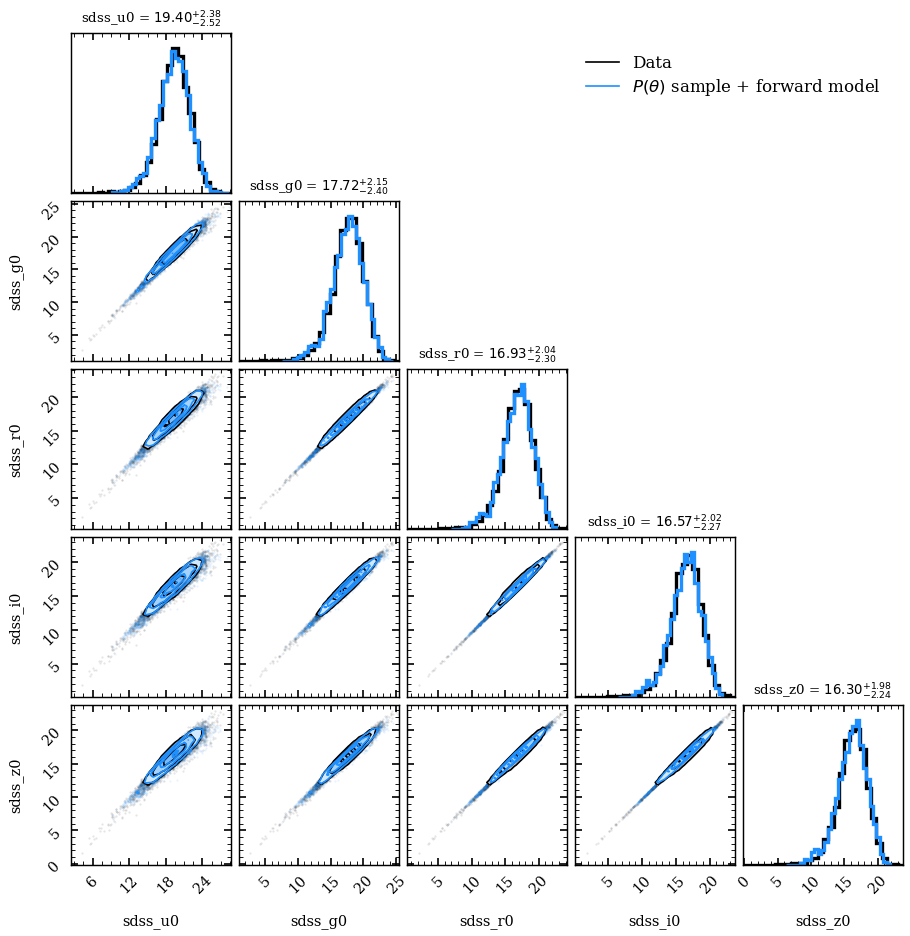

In [226]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = filters

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(samples,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [224]:
_samples_unt = samples.detach().cpu().numpy()
_samples = np.hstack([_samples_unt[:, -1:], 
               prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]), 
               _samples_unt[:, 3:-1]])

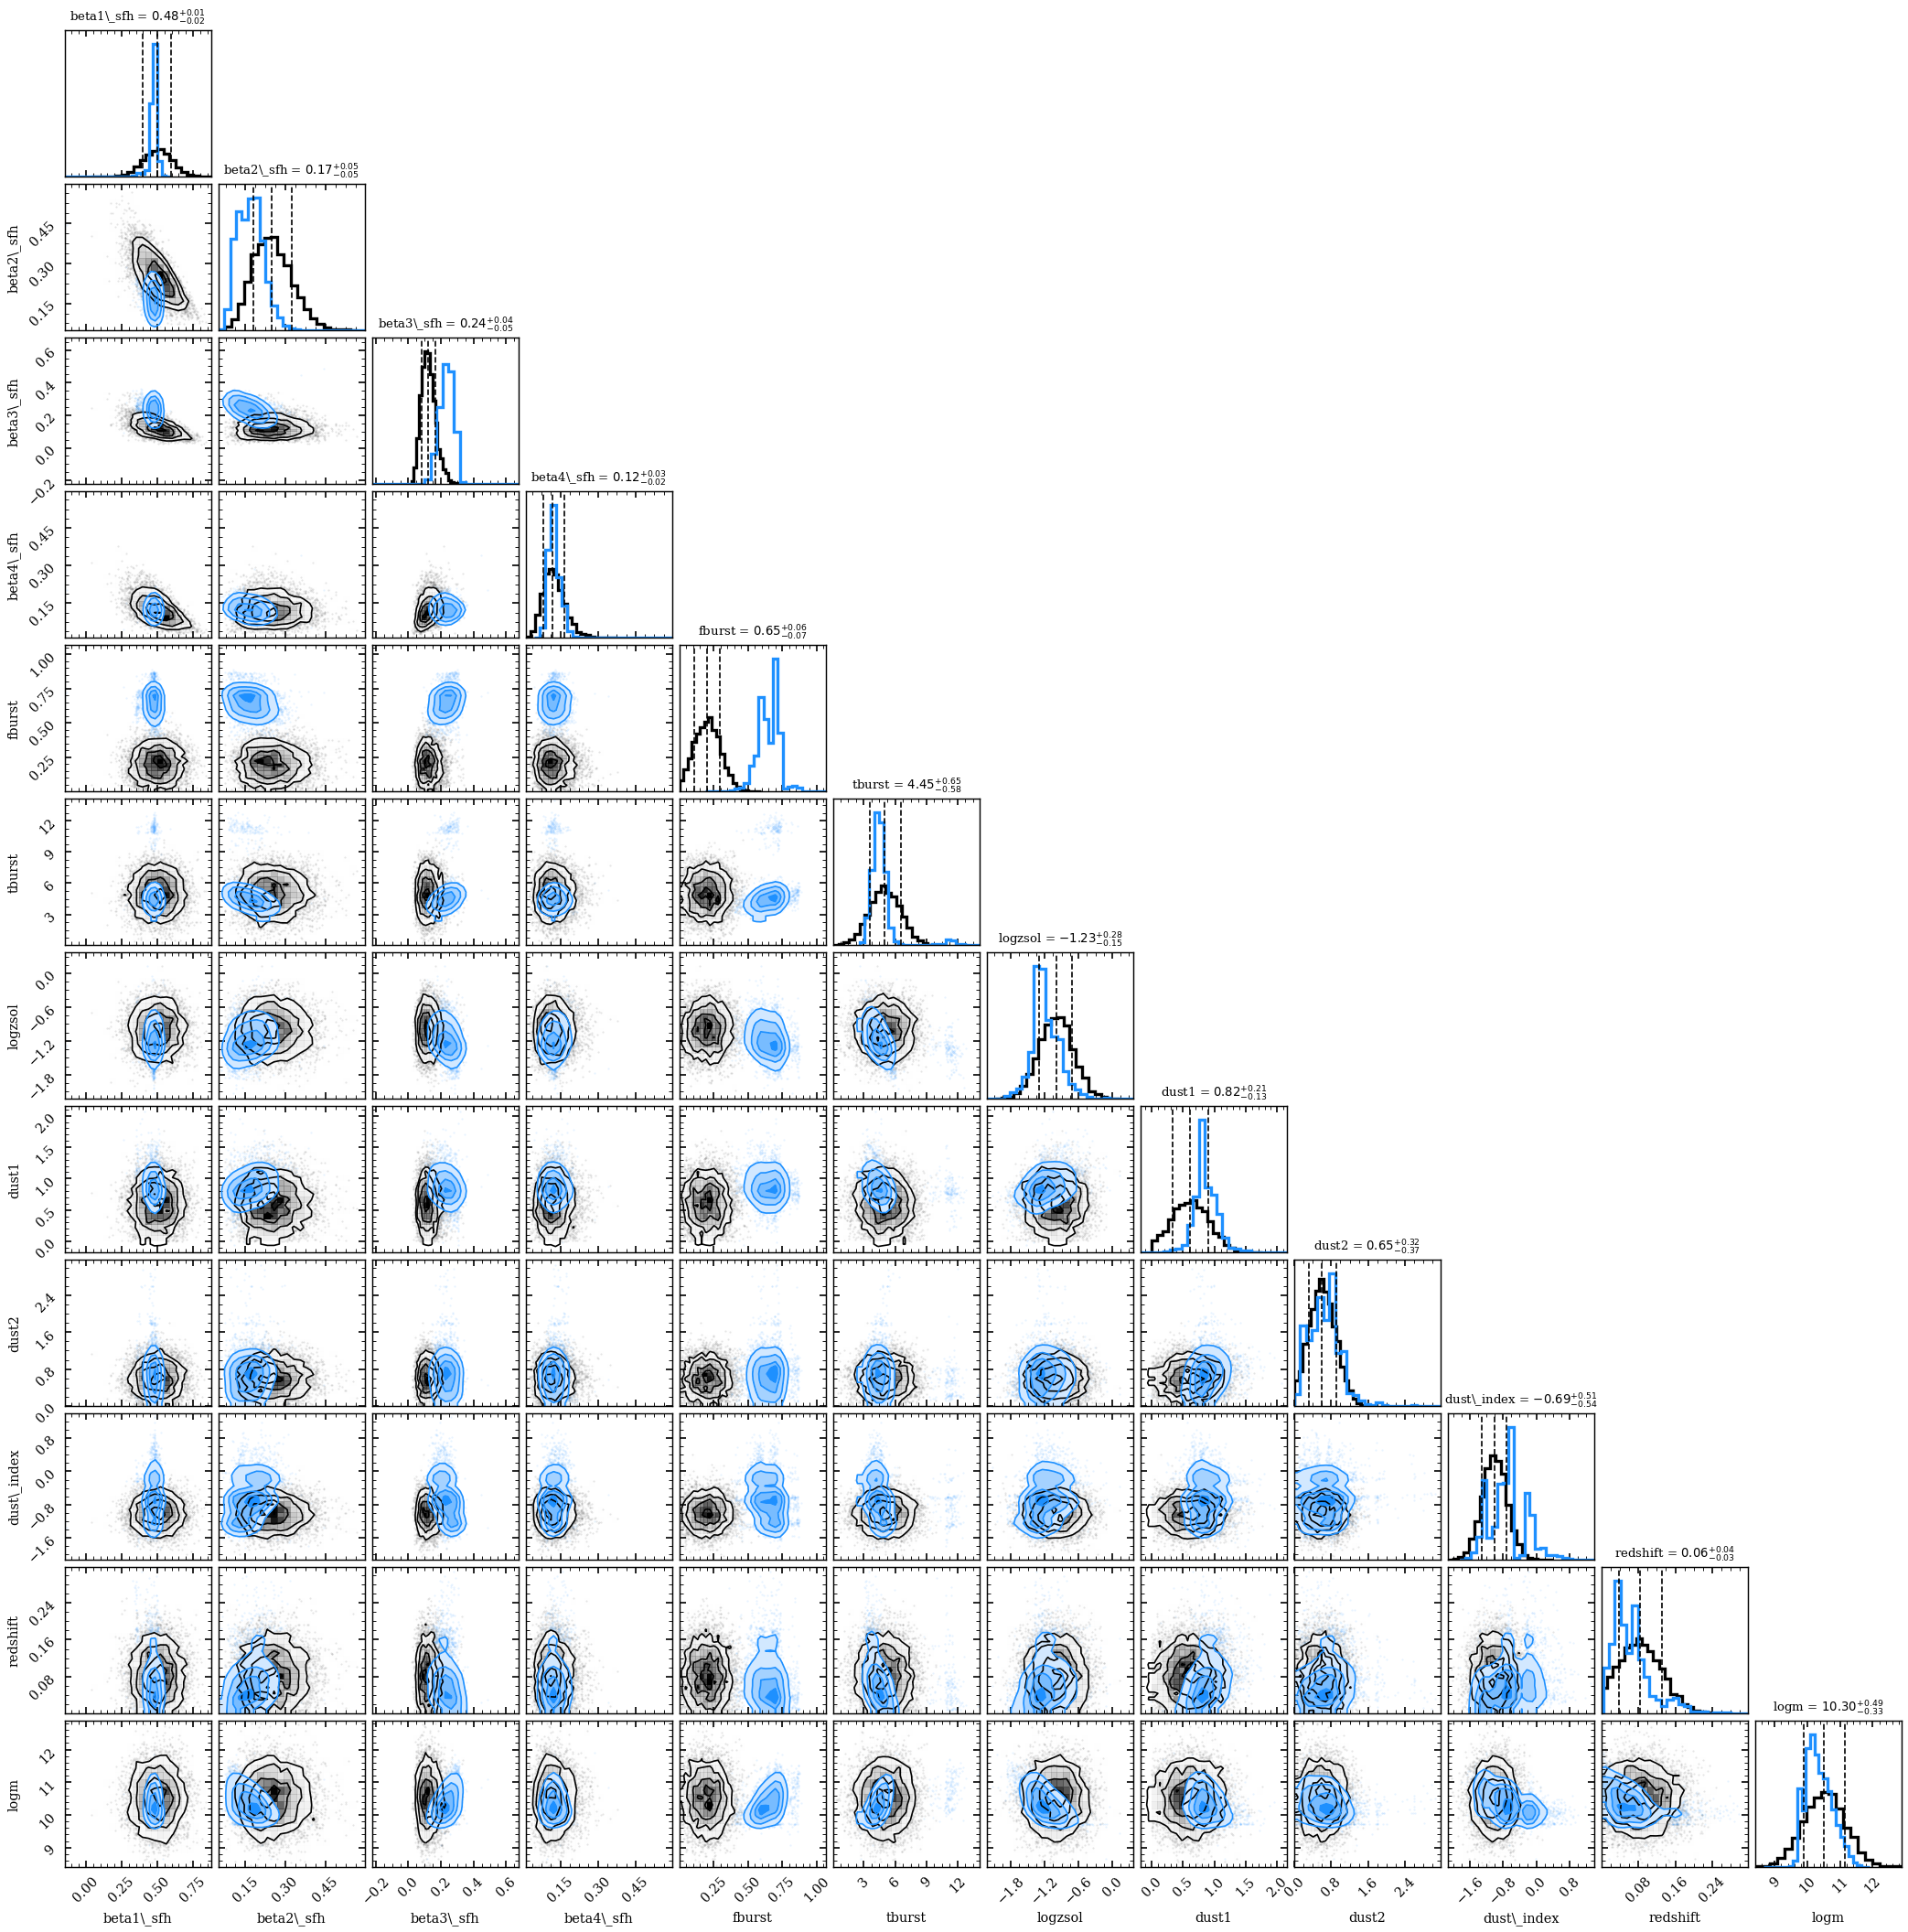

In [225]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]


# Distribution of beta coeffs
y_truth_trans = np.hstack([_thetas[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _thetas[:, 0:1], # stellar mass
                    ])

figure = corner.corner(y_truth_trans, 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=_labels,
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

y_truth_trans = np.hstack([_samples[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1], # stellar mass
                    ])

nf_plot = corner.corner(y_truth_trans, 
                  fig=figure, labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))